# Installing Darkflow

You can find the instruction from the official darkflow repo, but I will leave it here for convenience.

__1. install Cython__
   - pip install Cython
   
__2. clone/download the darkflow__
   - git clone https://github.com/thtrieu/darkflow.git
   
__3. install the darkflow__
   - python3 setup.py build_ext --inplace
   
__4. Install with pip globally (don't forget the last '.' dot)__
   - pip install .

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2

from lxml.etree import Element, SubElement, tostring, ElementTree
from darkflow.net.build import TFNet

# 转换txt为xml

In [ ]:
# 修改为你自己的路径
template_file = './dataset/scene00601.xml'
target_dir = './dataset/Annotations/'
image_dir = './dataset/images/'  # 图片文件夹
train_file = './dataset/collectedLabelxxyy.txt'  # 存储了图片信息的txt文件
 
with open(train_file) as f:
    trainfiles = f.readlines()  # 标注数据 格式(filename label x_min y_min x_max y_max)
 
file_names = []
tree = ElementTree()
 
for line in trainfiles:
    trainFile = line.split()
    file_name = trainFile[0]
 
    # 如果没有重复，则顺利进行。这给的数据集一张图片的多个框没有写在一起。
    if file_name not in file_names:
        file_names.append(file_name)
        lable = trainFile[1]
        xmin = trainFile[2]
        ymin = trainFile[3]
        xmax = trainFile[4]
        ymax = trainFile[5]
        if lable =='0':
            lable = 'bird'
            
        elif lable =='1':
            lable = 'car'
        
        elif lable =='2':
            lable = 'dog'
        
        elif lable =='3':
            lable = 'lizard'
        
        elif lable =='4':
            lable = 'turtle'

        tree.parse(template_file)
        root = tree.getroot()
        root.find('filename').text = file_name
 
        # size
        sz = root.find('size')
        im = cv2.imread(image_dir + file_name)#读取图片信息\
        
 
        sz.find('height').text = str(im.shape[0])
        sz.find('width').text = str(im.shape[1])
        sz.find('depth').text = str(im.shape[2])
 
        # object 因为我的数据集都只有一个框
        obj = root.find('object')
 
        obj.find('name').text = lable
        bb = obj.find('bndbox')
        bb.find('xmin').text = xmin
        bb.find('ymin').text = ymin
        bb.find('xmax').text = xmax
        bb.find('ymax').text = ymax
        # 如果重复，则需要添加object框
    else:
        lable = trainFile[1]
        xmin = trainFile[2]
        ymin = trainFile[3]
        xmax = trainFile[4]
        ymax = trainFile[5]
 
        xml_file = file_name.replace('jpg', 'xml')
        tree.parse(target_dir + xml_file)#如果已经重复
        root = tree.getroot()
 
        obj_ori = root.find('object')
 
        obj = copy.deepcopy(obj_ori)  # 注意这里深拷贝
 
        obj.find('name').text = lable
        bb = obj.find('bndbox')
        bb.find('xmin').text = xmin
        bb.find('ymin').text = ymin
        bb.find('xmax').text = xmax
        bb.find('ymax').text = ymax
        root.append(obj)
 
    xml_file = file_name.replace('JPEG', 'xml')
    print(xml_file)
    tree.write(target_dir + xml_file, encoding='utf-8')

# Options

There are several options to specify before running YOLO. 
- __model__: it specifies which model to use.
  - YOLO, YOLO-VOC, TINY-YOLO, TINY-YOLO-VOC, TINY-YOLO-4C are the available choices.
  
- __load__: it specifies where the pre-trained weights are. You can use your own weights after training on your own dataset. That is the other purpose.
  - I downloaded the [weight file](https://drive.google.com/drive/folders/0B1tW_VtY7onidEwyQ2FtQVplWEU) provided by the author of the darkflow

- __threshold__: it specifies the threshold for the confidence value of the predicted object. If you increase the value, the model will return fewer objects as result.

- __gpu__: it specifies whether you want to use GPU. If not specified, the model will be run soley on CPU.

In [10]:
#options = {"model": "cfg/yolo.cfg", "load": "bin/yolo.weights", "threshold": 0.1, "train":True,  "gpu": 1.0}
options = {"model": "cfg/yolo.cfg", 
           "load": -1,
           #"load": "bin/yolo.weights",
           "batch": 10,
           "lr": 0.000001,
           "epoch": 10,
           "train": True,
           "annotation": "./dataset/test/Annotations",
           "dataset": "./dataset/test/images/",
          }

In [11]:
tfnet = TFNet(options)

Parsing cfg/yolo.cfg
Loading None ...
Finished in 0.0s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 128, 128, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 128, 128, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 64, 64, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 64, 64, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 32, 32, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 32, 32, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 32, 32, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 32, 32, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 16, 16, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 16, 16, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky  

Forwarding 2 inputs ...
Total time = 1.1083645820617676s / 2 inps = 1.8044604026227742 ips
Post processing 2 inputs ...
Total time = 0.012991905212402344s / 2 inps = 153.94200983630626 ips


In [4]:
tfnet.train()


cfg/yolo.cfg parsing ./dataset/Annotations
Parsing for ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'turtle', 'lizard'] 
[====================>]100%  turtle000150.xml
Statistics:
bird: 150
car: 150
dog: 150

step 999 - loss 0.8467500805854797 - moving ave loss 0.9185061009237606
step 1000 - loss 0.8393497467041016 - moving ave loss 0.9105904655017947
Checkpoint at step 1000
step 1001 - loss 1.3687963485717773 - moving ave loss 0.9564110538087929
step 1002 - loss 0.8293914794921875 - moving ave loss 0.9437090963771324
step 1003 - loss 1.6880919933319092 - moving ave loss 1.0181473860726102
step 1004 - loss 0.8224866986274719 - moving ave loss 0.9985813173280964
step 1005 - loss 0.4405447542667389 - moving ave loss 0.9427776610219606
step 1006 - loss 0.8433591723442078 - moving ave loss 0.9328358121541853
step 1007 - loss 0.7034114599227905 - moving ave loss 0.9098933769310459
step 1008 - loss 0.6934586763381958 - moving ave loss 0.8882499068717609
step 1009 - loss 0.8827301859855652 - moving ave loss 0.8876979347831413
step 1010 - loss 0.6020287871360779 - moving ave loss 0.8591310200184349
step 1011 - loss 1.0600558519363403 - moving ave loss 0.8792235032102255
step 1012 - loss 0.643299937

step 1111 - loss 1.0227413177490234 - moving ave loss 0.876632339575834
step 1112 - loss 0.982211709022522 - moving ave loss 0.8871902765205029
step 1113 - loss 0.5642272233963013 - moving ave loss 0.8548939712080826
step 1114 - loss 0.960100531578064 - moving ave loss 0.8654146272450808
step 1115 - loss 0.5621830224990845 - moving ave loss 0.8350914667704812
step 1116 - loss 0.46589842438697815 - moving ave loss 0.7981721625321309
step 1117 - loss 0.5351370573043823 - moving ave loss 0.7718686520093561
step 1118 - loss 0.9010969996452332 - moving ave loss 0.7847914867729439
step 1119 - loss 0.6478226184844971 - moving ave loss 0.7710945999440992
step 1120 - loss 1.0236088037490845 - moving ave loss 0.7963460203245978
step 1121 - loss 0.741014301776886 - moving ave loss 0.7908128484698266
step 1122 - loss 1.0437192916870117 - moving ave loss 0.8161034927915451
step 1123 - loss 0.9146019220352173 - moving ave loss 0.8259533357159125
step 1124 - loss 0.9629645347595215 - moving ave loss 

AttributeError: 'NoneType' object has no attribute 'shape'

In [144]:
options = {"model": "cfg/yolo.cfg",
           "load": -1,
           "gpu": 1.0}

In [145]:
tfnet2 = TFNet(options)

Parsing cfg/yolo.cfg
Loading None ...
Finished in 0.0010008811950683594s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 128, 128, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 128, 128, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 64, 64, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 64, 64, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 32, 32, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 32, 32, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 32, 32, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 32, 32, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 16, 16, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 16, 16, 256)
 Init  |  Yep!  | conv 1x1p0_

# Display before boxing

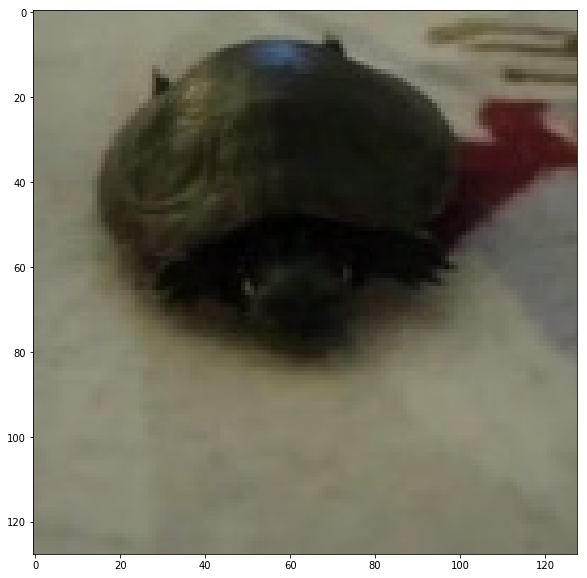

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(original_img)

In [151]:
def ifNear(x1,y1,x2,y2,width,height):
    if abs(x1-x2) < 0.15*width:
        if abs(y1-y2) < 0.15*width:
            return True
    return False

In [140]:
def boxing(original_img, predictions):
    newImage = np.copy(original_img)

    buf = list()
    for i in range(len(results)):
        if(results[i]['label'] != 'car' and results[i]['label'] != 'bird' and results[i]['label'] != 'dog' and results[i]['label'] != 'lizard' and results[i]['label'] != 'turtle'):
            buf.insert(0,i)
    
    for j in range(len(buf)):
        predictions.remove(predictions[buf[j]])
    
    height = original_img.shape[0]
    width = original_img.shape[1]
    buf2 = list()
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            if i != j and predictions[i]['label'] == predictions[j]['label']:
                x1i = predictions[i]['topleft']['x']
                y1i = predictions[i]['topleft']['y']
                x2i = predictions[i]['bottomright']['x']
                y2i = predictions[i]['bottomright']['y']
                x1j = predictions[j]['topleft']['x']
                y1j = predictions[j]['topleft']['y']
                x2j = predictions[j]['bottomright']['x']
                y2j = predictions[j]['bottomright']['y']
                if ifNear(x1i,y1i,x1j,y1j,width,height) and ifNear(x2i,y2i,x2j,y2j,width,height):
                    if predictions[i]['confidence'] >= predictions[j]['confidence']:
                        buf2.insert(0,j)
                    else:
                        buf2.insert(0,i)
                        
    for j in range(len(buf2)):
        predictions.remove(predictions[buf2[j]])
    
    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        label = result['label'] + " " + str(round(confidence, 3))

        if confidence > 0.1:
            if result['label'] == "car" or result['label'] == "bird" or result['label'] ==  "lizard"  or result['label'] == "dog" or result['label'] == "turtle":
                newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 2)
                newImage = cv2.putText(newImage, label, (top_x-15, top_y+15), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.6, (0, 230, 0), 1, cv2.LINE_AA)
            
    return newImage

# Boxing results

True

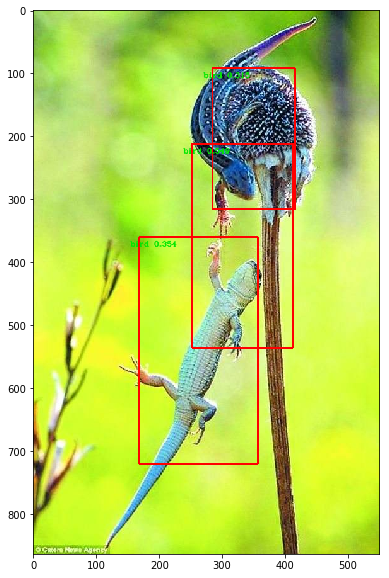

In [169]:
import pprint as pp

#original_img = cv2.imread("./sample_img/sample_multiple_objects.jpg")
original_img = cv2.imread("./dataset/sample/test9.jpg")
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
results = tfnet2.return_predict(original_img)

fig, ax = plt.subplots(figsize=(20, 10))
out_img = boxing(original_img, results)
ax.imshow(out_img)
cv2.imwrite('./out/test9out.jpg',cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))

# Calculating accuracy

In [146]:
import os
def calculateIOU(x1,y1,x2,y2,x3,y3,x4,y4):
    w1 = x2 - x1
    w2 = x4 - x3
    h1 = y2 - y1
    h2 = y4 - y3
    IOU_W = min(x1,x2,x3,x4)+w1+w2-max(x1,x2,x3,x4)
    IOU_H = min(y1,y2,y3,y4)+h1+h2-max(y1,y2,y3,y4)
    IOU_S = IOU_W * IOU_H
    if IOU_S<0:
        return 0
    whole_s = w1*h1 + w2*h2 - IOU_S
    return IOU_S/whole_s
    
calculateIOU(19,63,32,87,76,43,107,85 )

0

In [148]:
from lxml.etree import Element, SubElement, tostring, ElementTree
 
 
tree = ElementTree()

files = os.listdir('./dataset/test/Annotations')
lose = 0
count = 0
for fi in files:
    tree.parse('./dataset/test/Annotations/'+fi)
    root = tree.getroot()
    filename = root.find('filename').text
    obj = root.find('object')
    label = obj.find('name').text
    bb = obj.find('bndbox')
    xmin = int(bb.find('xmin').text)
    ymin = int(bb.find('ymin').text)
    xmax = int(bb.find('xmax').text)
    ymax = int(bb.find('ymax').text)

    original_img = cv2.imread("./dataset/test/images/"+filename)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    results = tfnet2.return_predict(original_img)
    
    buf = list()
    for i in range(len(results)):
        if(results[i]['label']== 'car' or results[i]['label']== 'bird' or results[i]['label']== 'dog' or results[i]['label']== 'lizard' or results[i]['label']== 'turtle'):
            buf.insert(0,i)

    if len(buf) == 0:
        lose += 1
    else:
        if len(buf) == 1:
            result = results[buf[0]]
        #print(filename +'  '+ str(result) + '\n')
        
        elif len(buf) > 1:
            tmp = 0
            index = 0
            for j in range(len(buf)):
                if results[buf[j]]['confidence'] > tmp:
                    tmp = results[buf[j]]['confidence']
                    index = buf[j]
            result = results[index]

        x1 = result['topleft']['x']
        y1 = result['topleft']['y']
        x2 = result['bottomright']['x']
        y2 = result['bottomright']['y']
        IOU = calculateIOU(x1,y1,x2,y2,xmin,ymin,xmax,ymax)
        print(filename +'  label:', result['label'], label, 'IOU=', IOU,  '\n')
        if result['label'] ==  label  and  IOU>0.5:
            count+=1
        else:
            lose+=1
        
    
print('correct =' + str(count) + ' lose = '+ str(lose) + '  accuracy = ' + str(count/(count+lose)))
            
        
    


bird000151.JPEG  label: turtle bird IOU= 0.18551822053951728 

bird000152.JPEG  label: lizard bird IOU= 0.7327652982184353 

bird000153.JPEG  label: turtle bird IOU= 0.5806995364517489 

bird000154.JPEG  label: bird bird IOU= 0.5437876960193003 

bird000155.JPEG  label: bird bird IOU= 0.6645569620253164 

bird000156.JPEG  label: lizard bird IOU= 0.42028985507246375 

bird000157.JPEG  label: bird bird IOU= 0.6358695652173914 

bird000158.JPEG  label: bird bird IOU= 0.8484848484848485 

bird000159.JPEG  label: bird bird IOU= 0.5535714285714286 

bird000160.JPEG  label: bird bird IOU= 0.6799031476997579 

bird000161.JPEG  label: bird bird IOU= 0.6522796352583586 

bird000163.JPEG  label: bird bird IOU= 0.7763975155279503 

bird000164.JPEG  label: bird bird IOU= 0.2172164119066774 

bird000165.JPEG  label: bird bird IOU= 0.7225453301402669 

bird000166.JPEG  label: bird bird IOU= 0.6586506346025384 

bird000167.JPEG  label: lizard bird IOU= 0.1054874800213106 

bird000168.JPEG  label: liza

lizard000177.JPEG  label: lizard lizard IOU= 0.7566137566137566 

lizard000178.JPEG  label: bird lizard IOU= 0.5686274509803921 

lizard000180.JPEG  label: lizard lizard IOU= 0.7940119760479042 

turtle000151.JPEG  label: turtle turtle IOU= 0.791005291005291 

turtle000153.JPEG  label: car turtle IOU= 0 

turtle000154.JPEG  label: turtle turtle IOU= 0.45951629863301785 

turtle000156.JPEG  label: turtle turtle IOU= 0.5405405405405406 

turtle000157.JPEG  label: turtle turtle IOU= 0.8044724770642202 

turtle000158.JPEG  label: turtle turtle IOU= 0.7781103035485251 

turtle000159.JPEG  label: lizard turtle IOU= 0.7276349148859109 

turtle000160.JPEG  label: turtle turtle IOU= 0.8245614035087719 

turtle000161.JPEG  label: turtle turtle IOU= 0.8952380952380953 

turtle000162.JPEG  label: turtle turtle IOU= 0.7971014492753623 

turtle000163.JPEG  label: dog turtle IOU= 0.418218085106383 

turtle000165.JPEG  label: turtle turtle IOU= 0.23420207068903962 

turtle000166.JPEG  label: turtle tu

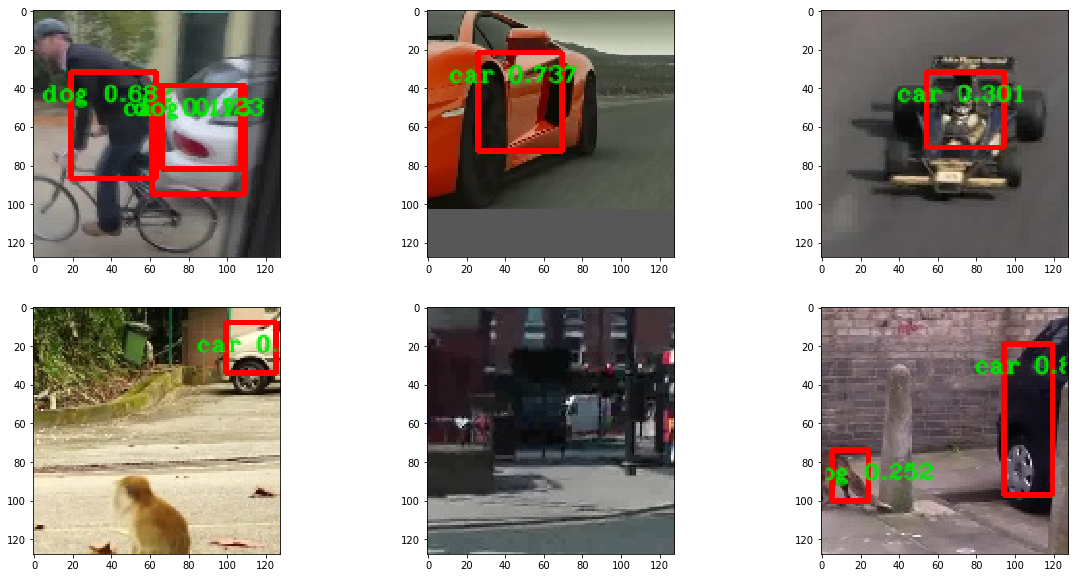

In [152]:
from math import ceil

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(6):
    original_img = cv2.imread("dataset/test/images/car00016" + str(i+1) + ".JPEG")
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    results = tfnet2.return_predict(original_img)
    
    ax[ceil(i/3)-1, i%3].imshow(boxing(original_img, results))